<a href="https://colab.research.google.com/github/IgorPutsenko/Data-Science-Pro/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d algord/fake-news

Dataset URL: https://www.kaggle.com/datasets/algord/fake-news
License(s): CC0-1.0
  0% 0.00/1.68M [00:00<?, ?B/s]
100% 1.68M/1.68M [00:00<00:00, 179MB/s]


In [ ]:
! pip install torch torchtext gensim

Загрузка библиотек

In [ ]:
import zipfile
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
# Путь к вашему архиву fake-news.zip
zip_file = '/content/fake-news.zip'

# Папка, куда вы хотите распаковать файлы
extract_dir = '/content/fake-news'

# Распаковка архива
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Вывод содержимого распакованной папки
os.listdir(extract_dir)


['FakeNewsNet.csv']

In [5]:
# Путь к файлу CSV
file_path = '/content/fake-news/FakeNewsNet.csv'

# Загрузка данных в датафрейм
df = pd.read_csv(file_path)

# Вывод первых нескольких строк для проверки
df.head()


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


Обработка данных

In [6]:
# Выбор нужных столбцов
df_subset = df[['title', 'news_url', 'source_domain', 'real']]

# Вывод первых нескольких строк для проверки
df_subset.head()


,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [7]:
df_subset.shape

(23196, 4)

In [8]:
# Проверка наличия null-значений
null_counts = df_subset.isnull().sum()
print("Количество null-значений по столбцам:")
print(null_counts)

Количество null-значений по столбцам:
title              0
news_url         330
source_domain    330
real               0
dtype: int64


In [9]:
# Удаление строк с null-значениями
df_subset = df_subset.dropna()

In [10]:
# Проверка, что null-значения были удалены
print("После удаления null-значений:")
print(df_subset.isnull().sum())

df_subset.shape

После удаления null-значений:
title            0
news_url         0
source_domain    0
real             0
dtype: int64


(22866, 4)

In [11]:
# Подсчет количества каждого класса
class_counts = df_subset['real'].value_counts()

# Вывод результатов
print("Баланс классов:")
print(class_counts)

Баланс классов:
real
1    17371
0     5495
Name: count, dtype: int64


In [12]:
# Функция для комбинирования текста из нескольких столбцов
def combine_text(row):
    return row['title'] + ' ' + row['news_url'] + ' ' + row['source_domain']

# Применение функции к датафрейму для создания нового столбца 'text'
df_subset['text'] = df_subset.apply(combine_text, axis=1)

# Вывод первых нескольких строк для проверки
df_subset.head()

,title,news_url,source_domain,real,text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1,Kandi Burruss Explodes Over Rape Accusation on...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1,People's Choice Awards 2018: The best red carp...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1,Colombian singer Maluma sparks rumours of inap...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [13]:
df_subset['text'][0]

"Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video) http://toofab.com/2017/05/08/real-housewives-atlanta-kandi-burruss-rape-phaedra-parks-porsha-williams/ toofab.com"

In [14]:
# Определение переменных TEXT и LABEL
TEXT = df_subset['text'].values
LABEL = df_subset['real'].values

In [15]:
# Создание датасета
dataset = pd.DataFrame({
    'text': TEXT,
    'label': LABEL
})

In [16]:
dataset

,text,label
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1
...,...,...
22861,Pippa Middleton wedding: In case you missed it...,1
22862,Zayn Malik & Gigi Hadid’s Shocking Split: Why ...,0
22863,Jessica Chastain Recalls the Moment Her Mother...,1
22864,"Tristan Thompson Feels ""Dumped"" After Khloé Ka...",0


In [17]:
words_counter = Counter()
for text in TEXT:
    words_counter.update(text.split())

# Вывод словаря с самыми часто встречающимися словами
print("Словарь слов:")
print(words_counter.most_common(10))  # вывод 10 самых частых слов

Словарь слов:
[('and', 4432), ('to', 3754), ('the', 3686), ('of', 2761), ('in', 2428), ('a', 2159), ('on', 2139), ('The', 2087), ('people.com', 1786), ('for', 1758)]


Разделение данных на обучающую и тестовою выборки

In [18]:
# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Вывод размеров обучающей и тестовой выборок для проверки
print("Размеры обучающей и тестовой выборок:")
print("Обучающая выборка:", train_data.shape)
print("Тестовая выборка:", test_data.shape)

Размеры обучающей и тестовой выборок:
Обучающая выборка: (18292, 2)
Тестовая выборка: (4574, 2)


In [19]:
test_data

,text,label
17659,Why Prince Harry Didn't Get a Prenup Before Ma...,0
7217,The cast of Halloweentown reunited to celebrat...,1
7495,Jessie James Decker Catches Married Woman Send...,1
11203,Jennifer Aniston casually dating again www.emi...,0
12870,Moana Hits Netflix Today So Let’s Celebrate Wi...,1
...,...,...
9437,Food Network Star Winners: Where Are They Now?...,1
20649,Rashad Jennings' Dancing With the Stars Finale...,1
10154,The First Author To Become A Billionaire Was? ...,1
19549,Rihanna Laughing Off Pregnancy Rumors: “She’s ...,0


Преобразование текстовых данных в тензоры PyTorch

In [20]:
train_texts = train_data['text'].tolist()
train_labels = train_data['label'].tolist()

test_texts = test_data['text'].tolist()
test_labels = test_data['label'].tolist()

In [22]:
# Определение размера пакета
batch_size = 32

# Создание DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [23]:
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in test_loader: 143


In [24]:
train_data

,text,label
11489,“This Is Us” Season 2 Poster Brings the Tears ...,1
4641,Charlie Sheen Selling Infamous Beverly Hills M...,1
10242,Famous Female Figure Skaters https://www.ranke...,1
11198,When Did Ben Affleck and Lindsay Shookus Start...,0
19695,Britney Spears dissected by plastic surgeon – ...,0
...,...,...
11964,Why the Public Option Isn't the Only Answer to...,1
21575,Jennifer Aniston’s Mother’s Caregiver Writing ...,0
5390,T.I. Pays Tribute to Ex Tiny on Her Birthday W...,1
860,Tyrese Gibson Calls Joint Custody Ruling a 'Wi...,1


In [25]:
# Собираем тексты для обучения Word2Vec
all_texts = [text.split() for text in train_data['text']]

# Параметры Word2Vec
vector_size = 100
window_size = 5
min_count = 1
workers = 4

# Создаем и обучаем Word2Vec
w2v_model = Word2Vec(
    sentences=all_texts,
    vector_size=vector_size,
    window=window_size,
    min_count=min_count,
    workers=workers
)

# Сохраняем модели
w2v_model.save('word2vec_model.bin')

In [26]:
similar_words = w2v_model.wv.most_similar('George')
print(similar_words)

[('Princess', 0.9972527623176575), ('Much', 0.9971710443496704), ('Elizabeth', 0.9968941807746887), ('what', 0.9966493844985962), ('will', 0.9965760707855225), ('Louis', 0.9962162971496582), ('and', 0.9961848855018616), ('Thomas', 0.9961674809455872), ('Charlotte', 0.9956515431404114), ('Priyanka', 0.9952967166900635)]


In [27]:
vector = w2v_model.wv['they']
print(vector)

[-0.11009281  0.2684426   0.08787521  0.0607732   0.00252345 -0.5115085
  0.10348056  0.6494361  -0.27437583 -0.30856603 -0.11870492 -0.44386828
 -0.07677257  0.11061883  0.1471003  -0.34799132  0.1710356  -0.22997694
 -0.06964897 -0.7456614   0.18368645  0.00428127  0.2444671  -0.1415482
 -0.07598346 -0.0030299  -0.26615322 -0.06417562 -0.19731948  0.02222373
  0.3175137   0.01095028  0.03835675 -0.3276495  -0.18751054  0.2001989
  0.09277475 -0.17282182 -0.13281797 -0.38529372  0.16232117 -0.27504706
 -0.12536569  0.16702685  0.12311122 -0.15365407 -0.17117009  0.01557585
  0.06244124  0.23080797  0.09569604 -0.2092833  -0.09527873 -0.20015271
 -0.11028547 -0.03250716  0.22059825  0.01213117 -0.14410776  0.18648905
  0.16298236  0.06610128  0.10090554 -0.00902187 -0.2851517   0.30533504
  0.04063622  0.2852174  -0.4152867   0.24891053 -0.10973921  0.27357367
  0.3315877   0.00972143  0.38193855  0.23864952  0.06971795  0.07765672
 -0.19098908  0.01825732 -0.23223427 -0.07405283 -0.13

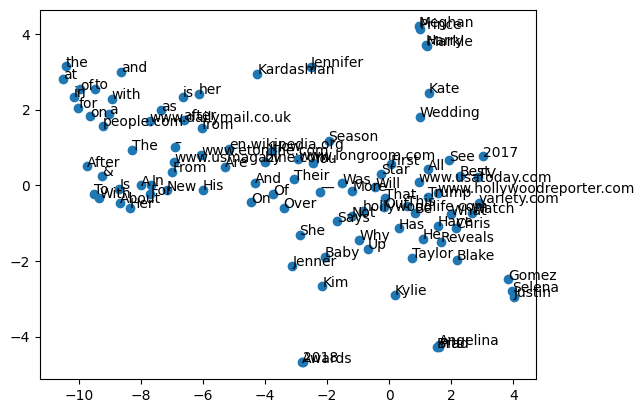

In [28]:
# Векторные представления всех слов
vectors = w2v_model.wv.vectors

# Применяем TSNE для снижения размерности до 2D
tsne = TSNE(n_components=2)
vectors_2d = tsne.fit_transform(vectors[:100])  # Для примера используем первые 100 слов

# Визуализируем
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
for label, x, y in zip(w2v_model.wv.index_to_key[:100], vectors_2d[:, 0], vectors_2d[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

# Рекуррентные нейронные сети (RNN)

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

In [30]:
# Преобразование текста в числовой формат
word_to_idx = {}
idx = 0
for text in train_texts:
    for word in text.split():
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx += 1

In [31]:
# Простой Dataset для загрузки данных с паддингом
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Преобразуем текст в числовую последовательность (индексы слов)
        text_indices = [self.word_to_idx[word] for word in text.split()]
        return torch.tensor(text_indices), torch.tensor(label)

# Создаем Dataset и DataLoader с паддингом
dataset = TextDataset(train_texts, train_labels, word_to_idx)

In [32]:
# Функция collate_fn для паддинга последовательностей в батче
def collate_fn(batch):
    texts, labels = zip(*batch)
    # Паддинг текстов до максимальной длины в батче
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.tensor(labels)

In [33]:
# DataLoader с использованием collate_fn
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Определяем модель RNN

In [34]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(embedded)
        # Берем только последний временной шаг для классификации
        output = self.fc(hidden[-1])
        return output

Epoch 1/10: 100%|██████████| 9146/9146 [06:39<00:00, 22.87it/s]


Epoch 1, Loss: 0.4498519167339068, Accuracy: 81.0955609009403%


Epoch 2/10: 100%|██████████| 9146/9146 [07:03<00:00, 21.60it/s]


Epoch 2, Loss: 0.31772777049892054, Accuracy: 87.26765799256506%


Epoch 3/10: 100%|██████████| 9146/9146 [06:35<00:00, 23.15it/s]


Epoch 3, Loss: 0.20825946266110473, Accuracy: 92.03476929805379%


Epoch 4/10: 100%|██████████| 9146/9146 [06:35<00:00, 23.14it/s]


Epoch 4, Loss: 0.10582673685118282, Accuracy: 96.06385305051388%


Epoch 5/10: 100%|██████████| 9146/9146 [06:37<00:00, 23.03it/s]


Epoch 5, Loss: 0.03993967226581018, Accuracy: 98.75355346599606%


Epoch 6/10: 100%|██████████| 9146/9146 [06:40<00:00, 22.83it/s]


Epoch 6, Loss: 0.01551306212554879, Accuracy: 99.48611414826154%


Epoch 7/10: 100%|██████████| 9146/9146 [06:38<00:00, 22.97it/s]


Epoch 7, Loss: 0.007447028098747394, Accuracy: 99.74852394489395%


Epoch 8/10: 100%|██████████| 9146/9146 [06:38<00:00, 22.93it/s]


Epoch 8, Loss: 0.004369945864031751, Accuracy: 99.89612945549968%


Epoch 9/10: 100%|██████████| 9146/9146 [06:42<00:00, 22.72it/s]


Epoch 9, Loss: 0.004290594154903753, Accuracy: 99.87426197244697%


Epoch 10/10: 100%|██████████| 9146/9146 [07:07<00:00, 21.39it/s]


Epoch 10, Loss: 0.002297169396457464, Accuracy: 99.94533129236825%


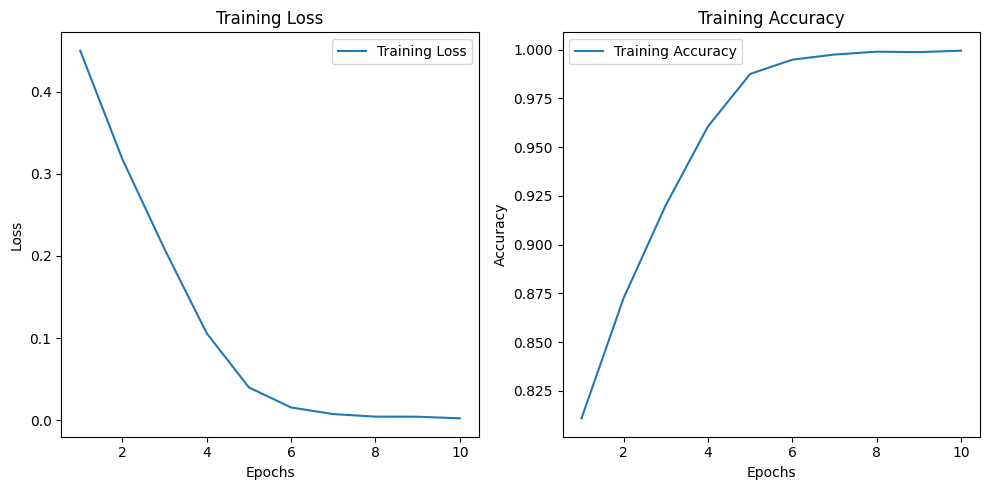

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Определение параметров модели и обучения
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 100
output_dim = 2  # В данном примере 2 класса

# Инициализация модели, функции потерь и оптимизатора
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Подготовка DataLoader с использованием collate_fn
train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Обучение модели с сохранением истории loss и accuracy
epochs = 10
loss_history = []
accuracy_history = []

for epoch in range(epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Вычисление accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Сохранение истории loss и accuracy для построения графиков
    loss_history.append(epoch_loss / len(train_loader))
    accuracy_history.append(correct / total)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {100 * correct / total}%')

# Построение графиков loss и accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Сохранение модели
torch.save(model.state_dict(), 'rnn_model_1.pth')


In [36]:
# Преобразование текста в числовой формат
word_to_idx = {}
idx = 0
for text in test_texts:
    for word in text.split():
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx += 1

In [37]:
# Создаем dataset_test и DataLoader с паддингом
dataset_test = TextDataset(test_texts, test_labels, word_to_idx)

In [38]:
# DataLoader с использованием collate_fn
test_loader = DataLoader(dataset_test, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [39]:
# import torch
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
# import matplotlib.pyplot as plt

# # Переводим модель в режим оценки
# model.eval()

# # Список для хранения предсказанных и реальных меток
# predicted_labels = []
# true_labels = []

# # Проходим по тестовой выборке
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         predicted_labels.extend(predicted.cpu().numpy())
#         true_labels.extend(labels.cpu().numpy())

# # Преобразуем списки в numpy массивы для удобства
# predicted_labels = np.array(predicted_labels)
# true_labels = np.array(true_labels)

# # Вычисляем accuracy
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f'Accuracy: {accuracy}')

# # Вычисляем F1-score
# f1 = f1_score(true_labels, predicted_labels)
# print(f'F1-score: {f1}')

# # Вычисляем ROC AUC и строим ROC кривую
# roc_auc = roc_auc_score(true_labels, predicted_labels)
# print(f'ROC AUC: {roc_auc}')

# # Строим ROC кривую
# fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
# roc_auc_curve = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_curve:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()


In [40]:
from torch.utils.data import DataLoader

# Определение размера пакета
batch_size = 32

# Создание итераторов для обучающей и тестовой выборок
train_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Преобразование текстовых данных в тензоры PyTorch
train_texts = train_data['text'].tolist()
train_labels = train_data['label'].tolist()

test_texts = test_data['text'].tolist()
test_labels = test_data['label'].tolist()

In [42]:
# Преобразование текста в числовой формат
word_to_idx = {}
idx = 0
for text in train_texts:
    for word in text.split():
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx += 1

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Ваш класс TextDataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Преобразуем текст в числовую последовательность (индексы слов)
        text_indices = [self.word_to_idx[word] for word in text.split()]
        return torch.tensor(text_indices), torch.tensor(label)

# Функция collate_fn для паддинга последовательностей в батче
def collate_fn(batch):
    texts, labels = zip(*batch)
    # Паддинг текстов до максимальной длины в батче
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.tensor(labels)

# # Пример данных
# train_texts = ['This is a sample text', 'Another example of text']
# train_labels = [0, 1]
# word_to_idx = {'This': 0, 'is': 1, 'a': 2, 'sample': 3, 'text': 4, 'Another': 5, 'example': 6, 'of': 7}

# Создаем Dataset и DataLoader с паддингом
dataset = TextDataset(train_texts, train_labels, word_to_idx)

# Разделение данных на обучающую и тестовую выборки
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Определение размера пакета
batch_size = 32

# Создание DataLoader для обучающей и тестовой выборок
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Собираем тексты для обучения Word2Vec
all_texts = [text.split() for text in train_texts]

# Параметры модели Word2Vec
vector_size = 100
window_size = 5
min_count = 1
workers = 4

# Создаем и обучаем модель Word2Vec
w2v_model = Word2Vec(
    sentences=all_texts,
    vector_size=vector_size,
    window=window_size,
    min_count=min_count,
    workers=workers
)

# Сохраняем модель в файл
w2v_model.save('word2vec_model.bin')

In [44]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        return self.fc(output[:, -1, :])

# Параметры модели
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 100
output_dim = 2  # Для бинарной классификации
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [46]:
import matplotlib.pyplot as plt

epochs = 3
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {epoch_accuracy * 100}%')

# Сохранение модели
torch.save(model.state_dict(), 'rnn_model_2.pth')


Epoch 1/3: 100%|██████████| 458/458 [00:13<00:00, 33.21it/s]


Epoch 1, Loss: 0.556347169209776, Accuracy: 75.86960978609991%


Epoch 2/3: 100%|██████████| 458/458 [00:10<00:00, 41.70it/s]


Epoch 2, Loss: 0.5514233032949106, Accuracy: 75.89694526071209%


Epoch 3/3: 100%|██████████| 458/458 [00:10<00:00, 41.65it/s]

Epoch 3, Loss: 0.5451685597542592, Accuracy: 76.190801612793%


In [47]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f'Test Accuracy: {test_accuracy * 100}%')


Test Accuracy: 75.97704290789832%


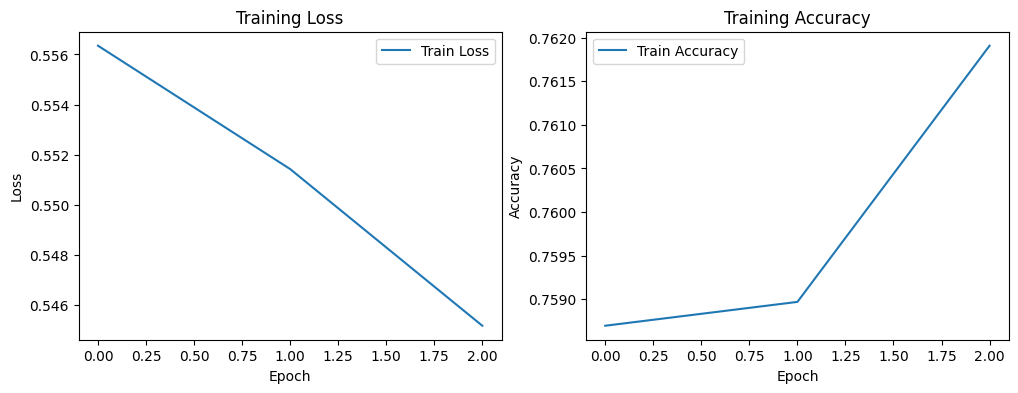

In [48]:
plt.figure(figsize=(12, 4))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [49]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import numpy as np

# Переводим модель в режим оценки
model.eval()

# Списки для хранения истинных меток и предсказанных вероятностей
true_labels = []
pred_labels = []
pred_probs = []

# Без градиентов
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Преобразуем списки в numpy массивы
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probs = np.array(pred_probs)


In [50]:
# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# F1-score
f1 = f1_score(true_labels, pred_labels)
print(f'F1-score: {f1:.4f}')

# ROC AUC
roc_auc = roc_auc_score(true_labels, pred_probs)
print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 0.7598
F1-score: 0.8631
ROC AUC: 0.5340


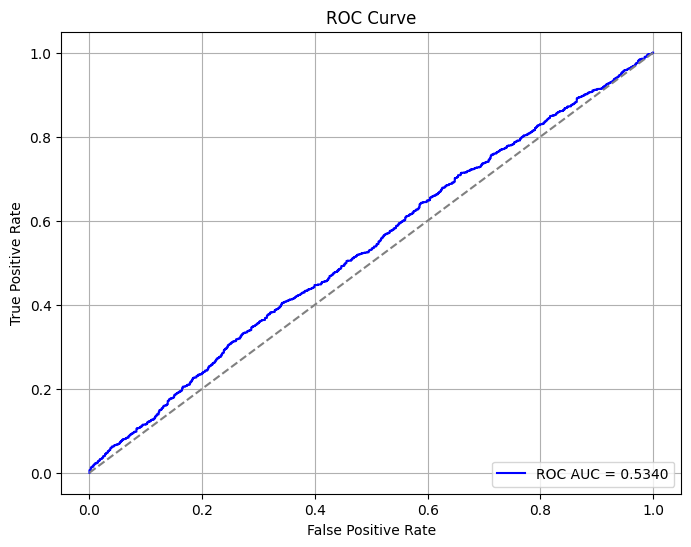

In [51]:
import matplotlib.pyplot as plt

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Улyчшение RNN
* 8 эпох
* optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [52]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        return self.fc(output[:, -1, :])

# Параметры модели
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 100
output_dim = 2  # Для бинарной классификации
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [53]:
import matplotlib.pyplot as plt

epochs = 8
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {epoch_accuracy * 100}%')

# Сохранение модели
torch.save(model.state_dict(), 'rnn_model_2.pth')

Epoch 1/8: 100%|██████████| 458/458 [00:13<00:00, 34.98it/s]


Epoch 1, Loss: 0.5652605399294192, Accuracy: 74.09963780496139%


Epoch 2/8: 100%|██████████| 458/458 [00:11<00:00, 40.15it/s]


Epoch 2, Loss: 0.5552886587173137, Accuracy: 75.71926467573293%


Epoch 3/8: 100%|██████████| 458/458 [00:11<00:00, 40.56it/s]


Epoch 3, Loss: 0.5518881515254099, Accuracy: 75.82860657418165%


Epoch 4/8: 100%|██████████| 458/458 [00:11<00:00, 40.88it/s]


Epoch 4, Loss: 0.5451575747353541, Accuracy: 76.04729037107907%


Epoch 5/8: 100%|██████████| 458/458 [00:11<00:00, 40.56it/s]


Epoch 5, Loss: 0.532087611058914, Accuracy: 77.16121096152531%


Epoch 6/8: 100%|██████████| 458/458 [00:10<00:00, 42.33it/s]


Epoch 6, Loss: 0.5162231373930082, Accuracy: 77.6190801612793%


Epoch 7/8: 100%|██████████| 458/458 [00:10<00:00, 42.20it/s]


Epoch 7, Loss: 0.5007359002224743, Accuracy: 78.39814118772637%


Epoch 8/8: 100%|██████████| 458/458 [00:10<00:00, 45.64it/s]

Epoch 8, Loss: 0.4857148828725107, Accuracy: 79.34804893049956%


In [54]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f'Test Accuracy: {test_accuracy * 100}%')


Test Accuracy: 78.81934954905712%


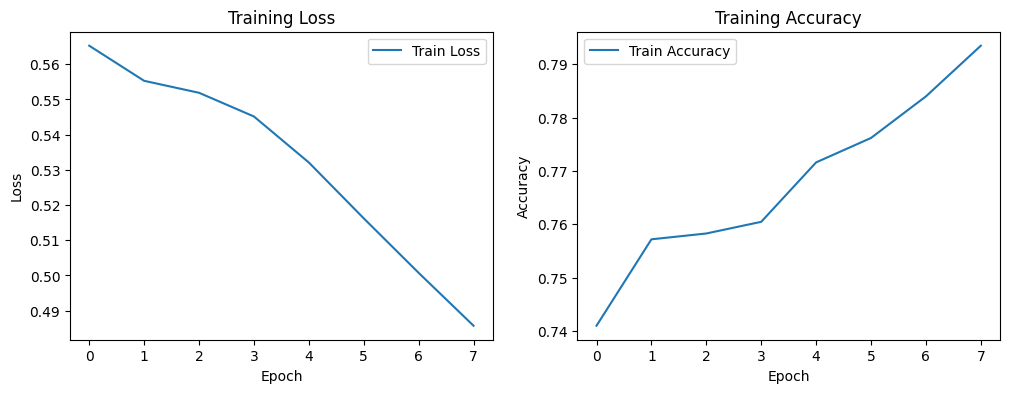

In [55]:
plt.figure(figsize=(12, 4))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [56]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import numpy as np

# Переводим модель в режим оценки
model.eval()

# Списки для хранения истинных меток и предсказанных вероятностей
true_labels = []
pred_labels = []
pred_probs = []

# Без градиентов
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Преобразуем списки в numpy массивы
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probs = np.array(pred_probs)


In [57]:
# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# F1-score
f1 = f1_score(true_labels, pred_labels)
print(f'F1-score: {f1:.4f}')

# ROC AUC
roc_auc = roc_auc_score(true_labels, pred_probs)
print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 0.7882
F1-score: 0.8726
ROC AUC: 0.7081


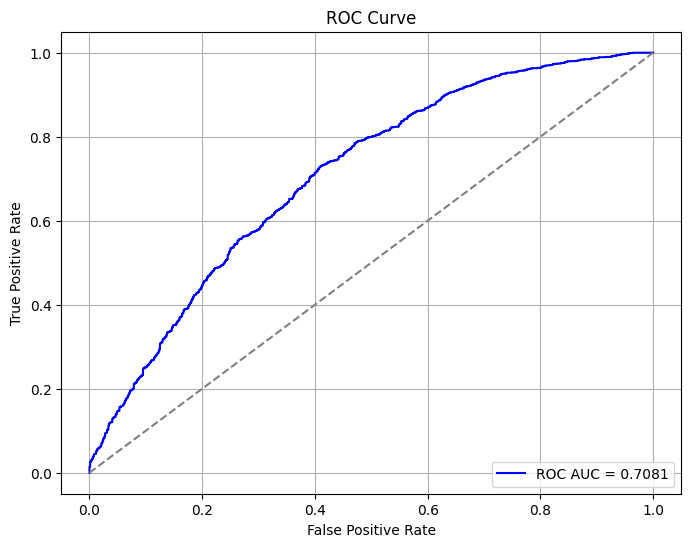

In [58]:
import matplotlib.pyplot as plt

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Модель RNN удовлетворяет требованиям практической работы:
* Accuracy: 0.7882
* F1-score: 0.8726
* ROC AUC: 0.7081


# LSTM (Long Short-Term Memory)

LSTM — это особый тип RNN, разработанный для решения проблемы долгосрочных зависимостей, с которыми сталкиваются обычные RNN. LSTM имеет более сложную структуру, включая специальные механизмы, называемые "ячейками памяти" и "воротами" (gates), которые помогают контролировать поток информации.

### Основные компоненты:

* Ячейка памяти (cell state): Хранит долгосрочную информацию.
* Ворота забывания (forget gate): Решает, какая информация из ячейки памяти будет выброшена.
* Ворота ввода (input gate): Определяет, какая новая информация будет сохранена в ячейке памяти.
* Ворота выхода (output gate): Определяет, какая информация из ячейки памяти будет использована для вычисления текущего состояния.

Эти механизмы позволяют LSTM сохранять и извлекать информацию на более длинных временных промежутках по сравнению с традиционными RNN.


Epoch 1, Loss: 0.5273141577254217, Accuracy: 76.94%
Epoch 2, Loss: 0.4023250068118999, Accuracy: 83.61%
Epoch 3, Loss: 0.313956203793204, Accuracy: 87.64%
Epoch 4, Loss: 0.23516265647770537, Accuracy: 91.29%
Epoch 5, Loss: 0.16540293440255274, Accuracy: 94.27%
Epoch 6, Loss: 0.10698009132078186, Accuracy: 96.58%
Epoch 7, Loss: 0.06265292934388102, Accuracy: 98.12%
Epoch 8, Loss: 0.038457900564558396, Accuracy: 98.82%
Epoch 9, Loss: 0.02341765577732799, Accuracy: 99.36%
Epoch 10, Loss: 0.017456079476083908, Accuracy: 99.47%


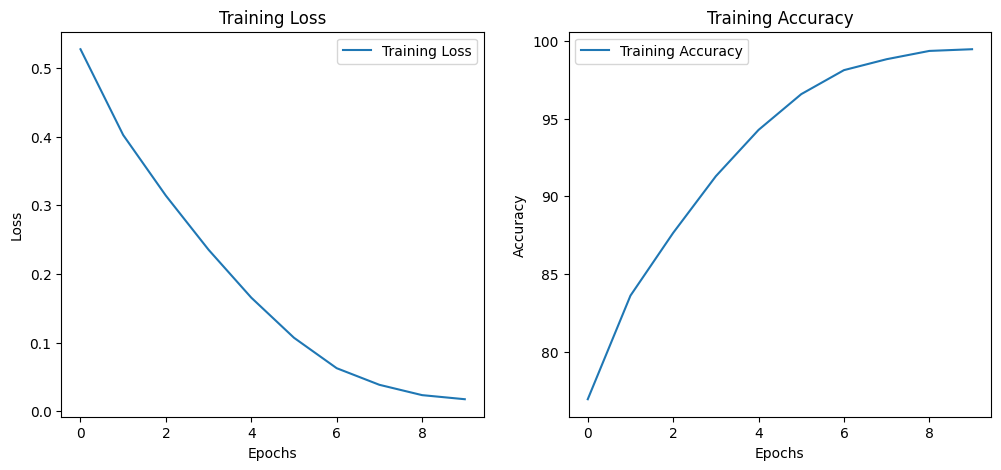

Accuracy: 0.8213
F1-score: 0.8818
ROC AUC: 0.8365


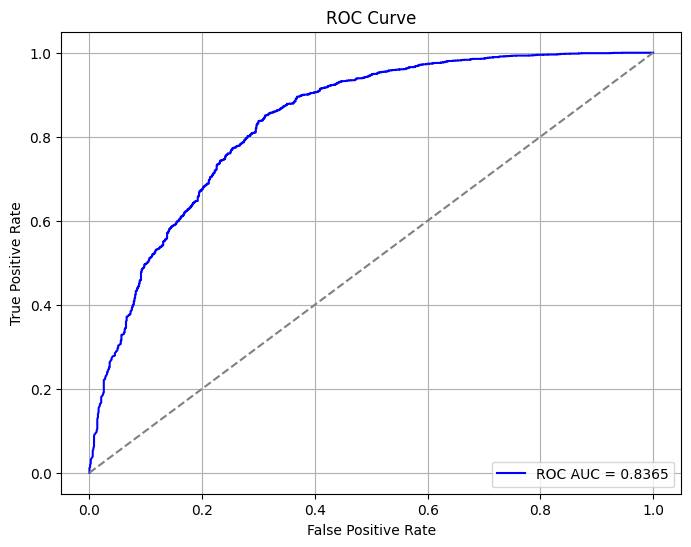

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

class ImprovedRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob):
        super(ImprovedRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

# Параметры модели
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 100
output_dim = 2  # Для бинарной классификации
n_layers = 2
dropout_prob = 0.5

model = ImprovedRNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция collate_fn для паддинга последовательностей в батче
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
    return padded_texts, torch.tensor(labels)

# Создание DataLoader с collate_fn
batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# # Обучение модели
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy:.2f}%')

# Графики точности и потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

# Оценка модели на тестовой выборке
model.eval()
true_labels = []
pred_labels = []
pred_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probs = np.array(pred_probs)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_probs)
print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Модель RNN с архитектурой LSTM удовлетворяет требованиям практической работы:
* Accuracy: 0.7882
* F1-score: 0.8575
* ROC AUC: 0.8244

# GRU (Gated Recurrent Unit)

GRU — это еще один тип RNN, который также предназначен для борьбы с проблемами долгосрочных зависимостей, но с более простой структурой по сравнению с LSTM. GRU объединяет некоторые из функций ворот LSTM, уменьшая количество параметров и вычислительных затрат.

### Основные компоненты:

* Ворота обновления (update gate): Решает, сколько информации из предыдущего состояния будет сохранено.
* Ворота сброса (reset gate): Определяет, сколько информации из предыдущего состояния будет отброшено.
* GRU проще и быстрее для обучения, чем LSTM, и часто дает схожие результаты, особенно при работе с не очень длинными последовательностями.



Epoch 1, Loss: 0.512438013368819, Accuracy: 78.32%
Epoch 2, Loss: 0.38261090804656, Accuracy: 84.56%
Epoch 3, Loss: 0.29217034334308717, Accuracy: 88.83%
Epoch 4, Loss: 0.211346546273402, Accuracy: 92.11%
Epoch 5, Loss: 0.13897789440699346, Accuracy: 95.35%
Epoch 6, Loss: 0.08441901494246627, Accuracy: 97.27%
Epoch 7, Loss: 0.04535594750114404, Accuracy: 98.72%
Epoch 8, Loss: 0.030272946538333477, Accuracy: 99.16%
Epoch 9, Loss: 0.020113537332368914, Accuracy: 99.44%
Epoch 10, Loss: 0.015766781577499844, Accuracy: 99.60%


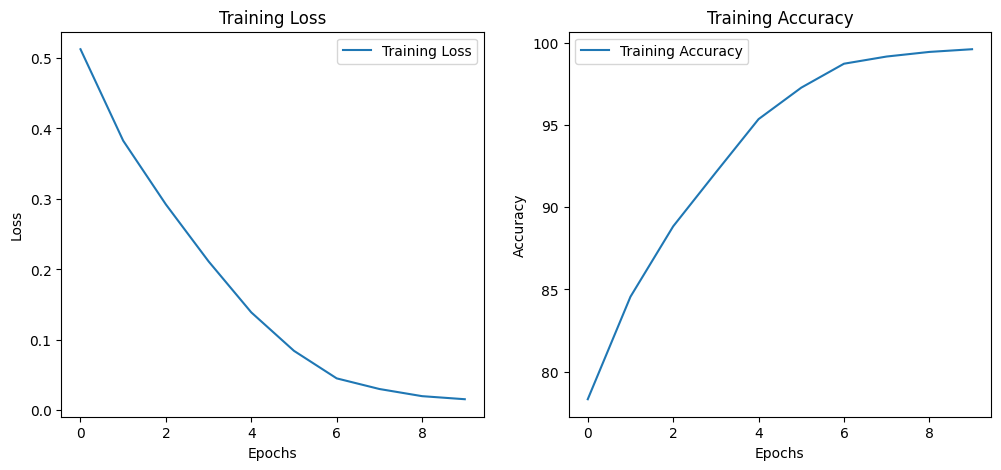

Accuracy: 0.8043
F1-score: 0.8709
ROC AUC: 0.8221


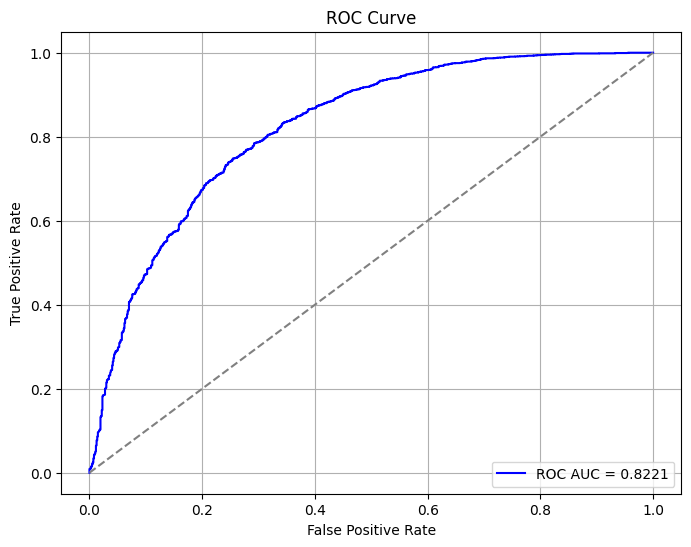

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)
        out = self.dropout(gru_out[:, -1, :])
        return self.fc(out)

# Параметры модели
vocab_size = len(word_to_idx)
embedding_dim = 50
hidden_dim = 100
output_dim = 2  # Для бинарной классификации
n_layers = 2
dropout_prob = 0.5

model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_prob)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция collate_fn для паддинга последовательностей в батче
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
    return padded_texts, torch.tensor(labels)

# Создание DataLoader с collate_fn
batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Обучение модели
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy:.2f}%')

# Графики точности и потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

# Оценка модели на тестовой выборке
model.eval()
true_labels = []
pred_labels = []
pred_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probs = np.array(pred_probs)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_probs)
print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Модель RNN с архитектурой GRU удовлетворяет требованиям практической работы:
* Accuracy: 0.8043
* F1-score: 0.8709
* ROC AUC: 0.8221

# Выводы
* RNN: Проста в реализации, но страдает от затухания или взрывного роста градиентов при работе с длинными последовательностями.
* LSTM: Более сложная структура с ячейками памяти и несколькими воротами, что позволяет лучше справляться с долгосрочными зависимостями.
* GRU: Упрощенная версия LSTM с меньшим количеством параметров, но аналогичной эффективностью в обработке последовательных данных.